In [4]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import yaml

In [5]:
pd.options.mode.copy_on_write = True

In [6]:
with open('../../config/satvis.yaml', 'r') as f:
    config = yaml.safe_load(f)

dir_dict = config['data_directories']
sub_basin_shp = dir_dict['sub_basin_shp']
cyano_data_shp = dir_dict['cyano_data_shp']

print(sub_basin_shp)
print(cyano_data_shp)

C:\Arbetsmapp\Shapefiler\Sub-basins_Baltic_Sea\Havsomr_SVAR_2016_3b.shp
C:\Arbetsmapp\BAWS\shp_data


In [8]:
basin_mapping_SVAR = {
    1: 'Bottenviken',
    2: 'Norra Kvarken',
    3: 'Bottenhavet',
    4: 'Ålands hav',
    5: 'Skärgårdshavet',
    6: 'Finska viken',
    7: 'Norra Gotlandshavet',
    8: 'Västra Gotlandshavet',
    9: 'Östra Gotlandshavet',
    10: 'Rigabukten',
    11: 'Gdanskbukten',
    12: 'Bornholmshavet & Hanöbukten',
    13: 'Arkonahavet & Södra Öresund',
    14: 'Bälthavet',
    15: 'Öresund',
    16: 'Kattegatt',
    17: 'Skagerrak',
}

In [9]:
def generate_filepaths(directory, pattern='', not_pattern='DUMMY_PATTERN',
                       pattern_list=[], endswith='',
                       only_from_dir=True):
    for path, subdir, fids in os.walk(directory):
        if only_from_dir:
            if path != directory:
                continue
        # Generator function (uses yield) https://docs.python.org/3/glossary.html#term-generator
        for f in fids:
            if pattern in f and not_pattern not in f and f.endswith(endswith):
                if any(pattern_list):
                    for pat in pattern_list:
                        if pat in f:
                            yield os.path.abspath(os.path.join(path, f))
                else:
                    yield os.path.abspath(os.path.join(path, f))

Set up dataframe containing geom definitions for each selected basin and append the total area of the geom in a new area column

In [10]:
basin_data = gpd.read_file(sub_basin_shp)
basin_data = basin_data.to_crs(epsg=3006)
basin_data_geometries = basin_data[['BASIN_NR', 'geometry']]
basin_data = basin_data_geometries.dissolve(by='BASIN_NR', as_index=False)
basin_data['basin_name'] = [basin_mapping_SVAR[item] for item in basin_data['BASIN_NR']]
basin_data['area'] = basin_data['geometry'].apply(lambda geom: int(geom.area))

In [11]:
# Default selection is BAWS area
baws_basins = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
selected_basins = [9]
boolean_filter = basin_data['BASIN_NR'].isin(selected_basins)
basin_data = basin_data.loc[boolean_filter, :].reset_index(drop=True)

In [12]:
basin_data.set_index('BASIN_NR')

,geometry,basin_name,area
BASIN_NR,,,
9,"POLYGON ((706381.131 6322005.715, 706379.902 6...",Östra Gotlandshavet,64599679622


<Axes: >

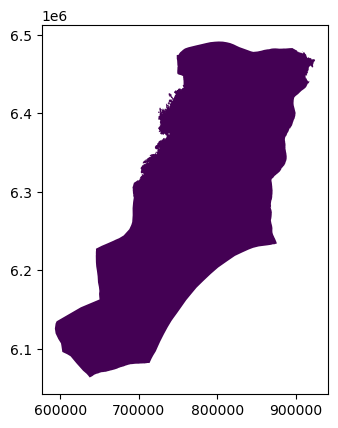

In [13]:
basin_data.plot('BASIN_NR')

# Time series

In [14]:
ds_time = xr.Dataset({'time': pd.date_range('2002-01-01', '2023-12-31', freq='D')})
ds_time

<xarray.Dataset> Size: 64kB
Dimensions:  (time: 8035)
Coordinates:
  * time     (time) datetime64[ns] 64kB 2002-01-01 2002-01-02 ... 2023-12-31
Data variables:
    *empty*

In [15]:
# xr.mfdataset
data_files = generate_filepaths(cyano_data_shp, endswith='.shp')
datasets = []

for cyano_data_file in data_files:
    gdf = gpd.read_file(cyano_data_file)
    # filename = os.path.basename(cyano_data_file)
    file_ts = pd.Timestamp(os.path.basename(cyano_data_file).split('.')[0].split('_')[-1])
    date = pd.to_datetime(file_ts)
    ds = xr.Dataset.from_dataframe(gdf)
    ds = ds.assign_coords(time=date)
    # ds['geometry'] = xr.DataArray(geometry, dims=['index'])
    # Tried but doesn't work
    # ds = ds.assign_attrs(crs='epsg:3006', description='Dataset projection')
    datasets.append(ds)
ds_all = xr.concat(datasets, dim='time')

In [16]:
ds_all

<xarray.Dataset> Size: 313MB
Dimensions:   (index: 9209, time: 2125)
Coordinates:
  * index     (index) int64 74kB 0 1 2 3 4 5 6 ... 9203 9204 9205 9206 9207 9208
  * time      (time) datetime64[ns] 17kB 2002-06-01 2002-06-02 ... 2023-09-26
Data variables:
    class     (time, index) float64 157MB 1.0 1.0 1.0 1.0 ... nan nan nan nan
    geometry  (time, index) object 157MB POLYGON ((190261 7342123, 206261 734...

In [17]:
# Expands the time column to include dates that don't have values
ds_merged = xr.merge([ds_time, ds_all])

In [18]:
ds_merged

<xarray.Dataset> Size: 1GB
Dimensions:   (time: 8035, index: 9209)
Coordinates:
  * time      (time) datetime64[ns] 64kB 2002-01-01 2002-01-02 ... 2023-12-31
  * index     (index) int64 74kB 0 1 2 3 4 5 6 ... 9203 9204 9205 9206 9207 9208
Data variables:
    class     (time, index) float64 592MB nan nan nan nan ... nan nan nan nan
    geometry  (time, index) object 592MB nan nan nan nan nan ... nan nan nan nan

In [19]:
ds_gdf = gpd.GeoDataFrame(ds_all.to_dataframe())

In [19]:
# TODO Figure out best way to store data to save computation time later
# Complete data file without any filters
ds_gdf.to_file('basin_9_02-22.gpkg', driver='GPKG')

In [20]:
# Filter on subsurface and surface blooms
blooms_all = ds_merged.where(ds_merged['class'].isin([2, 3]))

In [21]:
# Filter on clouds
clouds_all = ds_merged.where(ds_merged['class'].isin([1]))

In [22]:
# Convert cyano dataset to gdf
gdf_blooms = gpd.GeoDataFrame(blooms_all.to_dataframe())

In [23]:
# dropna needed to do bloom_area calculation
gdf_blooms = gdf_blooms.dropna()

In [24]:
# Convert clouds dataset to gdf
gdf_clouds = gpd.GeoDataFrame(clouds_all.to_dataframe())

In [25]:
# dropna needed to do cloud_area calculation
gdf_clouds = gdf_clouds.dropna()

In [26]:
# Construct dataset from basin data and add a time dimension
basin_ds = xr.Dataset(basin_data)
basin_ds = basin_ds.assign_coords(time=xr.DataArray(ds_merged['time']))

In [27]:
# Convert basin dataset back to GeoDataFrame
basin_gdf = gpd.GeoDataFrame(basin_ds.to_dataframe())

In [29]:
# Takes too long (probably hours)
# comp_ds = xr.combine_by_coords([basin_ds_coord_aligned, blooms_all_aligned])

In [30]:
# Returns the key:values of an index in a MultiIndex dataframe without dropping the index
# gdf_blooms.xs('2022-08-14', level='time', drop_level=False)

In [31]:
# Returns the key:values using two indices
# basin_stats = basin_gdf.xs((0, '2022-08-14'), level=('dim_0', 'time'))

In [32]:
ds_merged['time'].values

array(['2002-01-01T00:00:00.000000000', '2002-01-02T00:00:00.000000000',
       '2002-01-03T00:00:00.000000000', ...,
       '2023-12-29T00:00:00.000000000', '2023-12-30T00:00:00.000000000',
       '2023-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [33]:
basin_gdf.xs('2002-06-01', level='time')

,BASIN_NR,geometry,basin_name,area
dim_0,,,,
0,9,"POLYGON ((706381.131 6322005.715, 706379.902 6...",Östra Gotlandshavet,64599679622


In [34]:
# TODO Change to (selected) basin_gdf['BASIN_NR] index instead of range
# TODO Correct for loop so it properly calculates bloom area per day (currently same area every day)
for index in range(0, len(selected_basins)):
    for date in ds_merged['time'].values:
        if date in gdf_blooms.index.get_level_values('time'):
            basin_stats = basin_gdf.xs((index, date), level=('dim_0', 'time'))
            basin_bloom_overlap = gpd.overlay(gdf_blooms.xs(date, level='time', drop_level=False), basin_stats, how='intersection')
            bloom_area_sum = basin_bloom_overlap.area.sum()
            basin_gdf.loc[(index, date), 'bloom_area'] = bloom_area_sum

In [35]:
# Cloud area
for index in range(0, len(selected_basins)):
    for date in ds_merged['time'].values:
        if date in gdf_blooms.index.get_level_values('time'):
            basin_stats = basin_gdf.xs((index, date), level=('dim_0', 'time'))
            basin_cloud_overlap = gpd.overlay(gdf_clouds.xs(date, level='time', drop_level=False), basin_stats, how='intersection')
            cloud_area_sum = basin_cloud_overlap.area.sum()
            basin_gdf.loc[(index, date), 'cloud_area'] = cloud_area_sum

In [37]:
# FCA
basin_gdf['fca'] = basin_gdf['bloom_area'] / (basin_gdf['area'] - basin_gdf['cloud_area'])

In [38]:
basin_gdf

BASIN_NR                                           geometry  \
dim_0 time                                                                      
0     2002-01-01         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   
      2002-01-02         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   
      2002-01-03         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   
      2002-01-04         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   
      2002-01-05         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   
...                    ...                                                ...   
      2023-12-27         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   
      2023-12-28         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   
      2023-12-29         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   
      2023-12-30         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   
      2023-12-31         9  POLYGON ((706381.131 6322005.715, 706379.902 6...   

                           basin_name         area  bloom_area  cloud_area  \
dim_0 time                                                                   
0     2002-01-01  Östra Gotlandshavet  64599679622         NaN         NaN   
      2002-01-02  Östra Gotlandshavet  64599679622         NaN         NaN   
      2002-01-03  Östra Gotlandshavet  64599679622         NaN         NaN   
      2002-01-04  Östra Gotlandshavet  64599679622         NaN         NaN   
      2002-01-05  Östra Gotlandshavet  64599679622         NaN         NaN   
...                               ...          ...         ...         ...   
      2023-12-27  Östra Gotlandshavet  64599679622         NaN         NaN   
      2023-12-28  Östra Gotlandshavet  64599679622         NaN         NaN   
      2023-12-29  Östra Gotlandshavet  64599679622         NaN         NaN   
      2023-12-30  Östra Gotlandshavet  64599679622         NaN         NaN   
      2023-12-31  Östra Gotlandshavet  64599679622         NaN         NaN   

                  fca  
dim_0 time             
0     2002-01-01  NaN  
      2002-01-02  NaN  
      2002-01-03  NaN  
      2002-01-04  NaN  
      2002-01-05  NaN  
...               ...  
      2023-12-27  NaN  
      2023-12-28  NaN  
      2023-12-29  NaN  
      2023-12-30  NaN  
      2023-12-31  NaN  

[8035 rows x 7 columns]

In [39]:
# TODO Not sure if necessary, currently also done before plotting. I guess it depends on how the plotting function works
# Fill NaN rows in fca column with 0
basin_gdf['fca'].fillna(0)

dim_0  time      
0      2002-01-01    0.0
       2002-01-02    0.0
       2002-01-03    0.0
       2002-01-04    0.0
       2002-01-05    0.0
                    ... 
       2023-12-27    0.0
       2023-12-28    0.0
       2023-12-29    0.0
       2023-12-30    0.0
       2023-12-31    0.0
Name: fca, Length: 8035, dtype: float64

In [40]:
basin_gdf.to_file('basin_data.gpkg', driver='GPKG')